In [1]:
##installing fastbook on mbp
#pip install fastbook
#conda install fastbook

# #import libraries
from fastbook import *
from fastai.vision import *
from ipywidgets import HBox,VBox,widgets,Button,Checkbox,Dropdown,Layout,Box,Output,Label,FileUpload
import time

/Applications/anaconda_install/anaconda3/lib/python3.8/site-packages/fastbook/__init__.py:18: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [2]:
def search_images_ddg_dm(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    #res = urlread(url,data={'q':term}).decode()
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        try:
            data = urljson(requestUrl,data=params)
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(0.2)
    return L(urls)

In [3]:
term = 'bear'
url = 'https://duckduckgo.com/'

res = urlread(url,data={'q':term})
pattern = r'vqd=([\d-]+)\&'
searchObj = re.search(pattern, res)
print(searchObj)
assert searchObj

<re.Match object; span=(5409, 5495), match='vqd=3-102962969383839287948540327629905064265-182>


In [4]:
urls = search_images_ddg_dm('grizzly bear', max_images=100)
len(urls),urls[0]
time.sleep(10) 

In [5]:
mkdir 'images'

mkdir: images: File exists


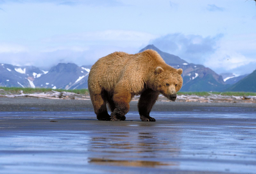

In [6]:
download_url(urls[0], 'images/bear.jpg')
im = Image.open('images/bear.jpg')
im.thumbnail((256,256))
im

In [7]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [8]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg_dm(f'{o} bear')
        download_images(dest, urls=results)

In [9]:
#looking at the list of images that we just downloaded
fns = get_image_files(path)
fns

(#705) [Path('bears/grizzly/00000158.jpg'),Path('bears/grizzly/00000170.jpg'),Path('bears/grizzly/00000038.jpg'),Path('bears/grizzly/00000010.jpg'),Path('bears/grizzly/00000004.jpg'),Path('bears/grizzly/00000212.jpg'),Path('bears/grizzly/00000206.jpg'),Path('bears/grizzly/00000207.jpg'),Path('bears/grizzly/00000213.jpg'),Path('bears/grizzly/00000005.jpg')...]

In [10]:
#finding the images which failed to download
failed = verify_images(fns)
failed

(#0) []

In [11]:
failed.map(Path.unlink);

In [12]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #defining the dependent and independent variable
    get_items=get_image_files,          #geting the image files
    splitter=RandomSplitter(valid_pct=0.2, seed=1), #function used to split the training/validation set
    get_y=parent_label,                             #using a function to get the labels
    item_tfms=Resize(128)                           #resizing all images
)


In [13]:
#telling fast.ai where to find our data
dls = bears.dataloaders(path)

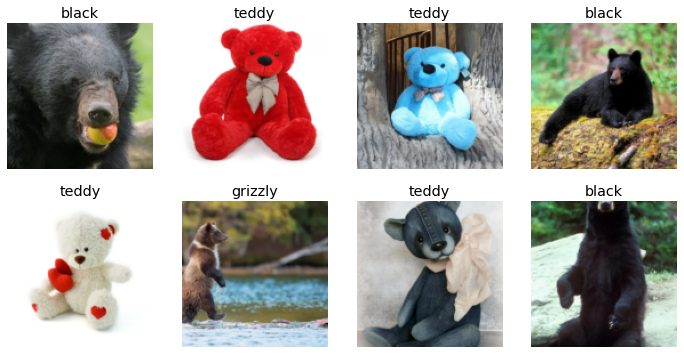

In [14]:
dls.valid.show_batch(max_n=8, nrows=2)

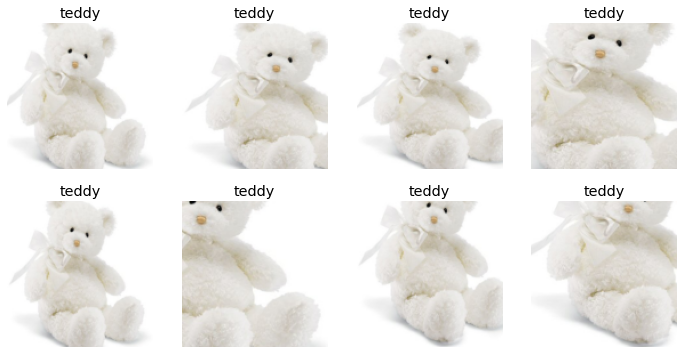

In [15]:
#augmenting our data to get a better result
bears = bears.new(item_tfms=RandomResizedCrop(128,min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8,nrows=2, unique=True)

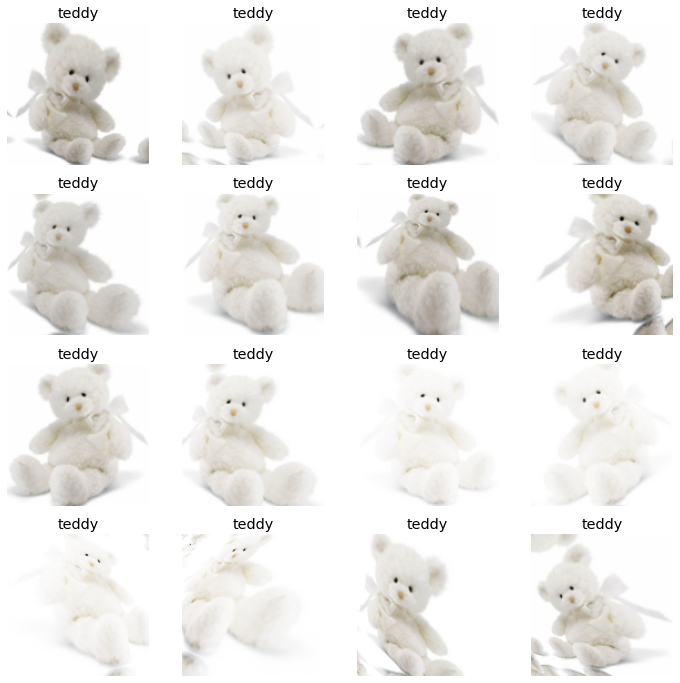

In [16]:
#we can also do other things except for crop like flipping, rotation, perspective warping, brightness changes, etc
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=16, nrows=4, unique=True)

In [17]:
#for this dataset, reverting using RandomResizedCrop with an image size of 224px

bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [18]:
# learn = cnn_learner(dls, resnet18, metrics=error_rate)
# learn.fine_tune(4)

In [19]:
# #hide_output
# cleaner = ImageClassifierCleaner(learn)
# cleaner

In [21]:
path = Path()
learn_inf = load_learner(path/'export.pkl')

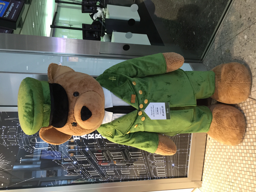

In [23]:
im = Image.open('IMG_4841.JPG')
im.thumbnail((256,256))
im

In [22]:
learn_inf.predict('IMG_4841.JPG')

('teddy', tensor(2), tensor([1.4562e-03, 2.3822e-05, 9.9852e-01]))

In [24]:
#building an 'app' in notebook

#here we have an upload button
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [25]:
#saving the uploaded image to 'img'
img = PILImage.create(btn_upload.data[-1])

In [26]:
#telling the widget to show our image
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [27]:
#predicting the image and using unpacking to save to appropriate variables.
pred,pred_idx,probs = learn_inf.predict(img)

In [28]:
#using a label to display the result of the prediction
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 0.9985')

In [29]:
#creating a run button to start our classifier
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [30]:
# defining an event handler to run a function when the button is pressed
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [31]:
# we then have to add them to a vbox to create a UI
btn_upload = widgets.FileUpload()

In [32]:
VBox([widgets.Label('Select your bear!'),
     btn_upload, btn_run, out_pl, lbl_pred])

In [33]:
# #adding in voila extension for making an app
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila

     |████████████████████████████████| 2.5 MB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 552 kB 18.1 MB/s eta 0:00:01
     |████████████████████████████████| 241 kB 16.3 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 8.1 MB/s  eta 0:00:01
     |████████████████████████████████| 64 kB 6.2 MB/s  eta 0:00:01
ERROR: spyder 4.1.4 requires pyqt5<5.13; python_version >= "3", which is not installed.
ERROR: spyder 4.1.4 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
ERROR: nbdev 1.1.12 has requirement nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
ERROR: jupyter-server 1.4.0 has requirement tornado>=6.1.0, but you'll have tornado 6.0.4 which is incompatible.
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
Enabling: voila
- Writing config: /Applications/anaconda_install/anaconda3/etc/jupyter
    - 